# Create Journal Publication Figures

By: Adam Li

## Note
Some of the notebook may not be "immediately runnable since

## List of figures:

1. ROC curve of fragility and 3 top feature representations (supplemental)
    - using hyperparameter tuning over 10 folds, save the FPR, TPR, FNR, TNR, pickled estimators and the AUC stats
    - show ROC curve with average +/- std TPR for the same FPR
    
2. AUC/PR curve to Fragility of fragility and all baseline features (Figure 4/5)
    - using hyperparameter tuning over 10 folds, save the FPR, TPR, FNR, TNR, pickled estimators and the AUC stats and then show a box+swarm plot of the AUCs with estimated effect size differences
  
3. Calibration curve (supplemental
    - predicted prob vs actual risk strata

4. Feature importances
    - use permutation

In [1]:
cd ../../../../../

/Users/adam2392/Documents/eztrack


In [10]:
import os
import re
import json
import collections
from pprint import pprint
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import scipy
import scipy.io
from natsort import natsorted, index_natsorted

import matplotlib.pyplot as plt
import seaborn as sns

import mne
import mne_bids
from mne_bids import read_raw_bids, BIDSPath

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from mne_bids.path import _find_matching_sidecar, get_entities_from_fname
from mne_bids.tsv_handler import _to_tsv, _from_tsv

# file utilities
from eztrack.base.utils.file_utils import _get_subject_recordings, \
        _get_subject_electrode_layout, _update_sidecar_tsv_byname, _get_prob_chs
from eztrack.utils import (_compute_samplepoints, _find_clin_onset_samples, 
                           _find_sz_samples, _sample_to_window, _map_events_to_window,
                           _map_seizure_event_to_window, Normalize, NumpyEncoder)
from eztrack.io import read_clinical_excel

# run fragility analysis
from eztrack.fragility import MvarModel, MinNormPerturbModel
from eztrack.io.read_result import _select_window
from eztrack.viz import generate_heatmap, _load_turbo
from eztrack.base.utils.preprocess_utils import (_resample_mat, _apply_threshold, 
                                                 _exponential_weight, _gaussian_weight)
from eztrack.base.statistics.sampling import subsample_matrix, _resample_seizure
_load_turbo()

# import statistics packages
# import lqrt
import scipy.stats

import matplotlib
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "arial"


from sklearn.model_selection import (KFold, StratifiedKFold, GroupKFold, LeaveOneGroupOut,
                                    GridSearchCV, train_test_split, GroupShuffleSplit,
                                    cross_validate, cross_val_score, cross_val_predict)
from sklearn.metrics import (average_precision_score, roc_auc_score, f1_score,
                            roc_curve, balanced_accuracy_score, accuracy_score, auc)
from sklearn.utils import resample
from eztrack.base.statistics.classifier import FragilityHeatmapClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from scipy import interp

from rerf.rerfClassifier import rerfClassifier

# functions related to the feature comparison experiment
from eztrack.base.publication.study import (load_patient_tfr, load_patient_graphstats, 
                                load_patient_dict, summarize_feature_comparisons,
                               check_mcnemar_significance, compute_acc_with_ci,
                               determine_feature_importances, compute_auc_optimism,
                               show_calibration_curves, extract_Xy_pairs, 
                                format_supervised_dataset, _sequential_aggregation,
                               _plot_roc_curve, tune_hyperparameters, _show_calibration_curve)
from mlxtend.evaluate import bootstrap_point632_score
import pingouin as pg
import dabest

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Define Utility Functions

In [11]:
def combine_patient_predictions(ytrues, ypred_probs, subject_groups, 
                                pat_predictions=None, pat_true=None):
    if pat_predictions is None or pat_true is None:
        pat_predictions = collections.defaultdict(list)
        pat_true = dict()
    
    # loop through things
    for ytrue, ypred_proba, subject in zip(ytrues, ypred_probs, subject_groups):
        pat_predictions[subject].append(ypred_proba)
        
        if subject not in pat_true: 
            pat_true[subject] = ytrue
        else:
            if pat_true[subject] != ytrue:
                raise RuntimeError('wtf subject should all match...')
    return pat_predictions, pat_true

In [12]:
def average_roc(fpr, tpr):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)
    
    n_splits = len(fpr)
    print(f"Computing average ROC over {n_splits}")
    for i in range(n_splits):
        interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(mean_fpr, interp_tpr))
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)   
    
    std_tpr = np.std(tprs, axis=0)
    return mean_fpr, tprs, aucs

In [13]:
def _subsample_matrices_in_time(mat_list):
    maxlen = min([x.shape[1] for x in mat_list])
    if maxlen < 50:
        raise RuntimeError("Preferably not under 50 samples...")
        
    mat_list = [x[:,:maxlen] for x in mat_list]
    return mat_list

In [14]:
def _load_patient_dict(datadir, kind='ieeg', verbose=True):
    """Load from datadir, sliced datasets as a dictionary <subject>: <list of datasets>."""
    patient_result_dict = collections.defaultdict(list)
    num_datasets = 0
    
    # get all files inside experiment
    trimmed_npz_fpaths = [x for x in datadir.rglob("*npz")]
    
    # get a hashmap of all subjects
    subjects_map = {}
    for fpath in trimmed_npz_fpaths:
        params = _parse_bids_filename(os.path.basename(fpath).split(f"{expname}-")[1], verbose=False)
        subjects_map[params['sub']] = 1

    if verbose:
        print(len(subjects_map))
        
    # loop through each subject
    subject_list = natsorted(subjects_map.keys())
    for subject in subject_list:
        if subject in pats_to_avg:
#             print("USING AVERAGE for: ", fpath)
            reference = 'average'
        else:
            reference = 'monopolar'
        subjdir = Path(datadir / reference / kind)
        fpaths = [x for x in subjdir.glob(f"*sub-{subject}_*npz")]
        
        # load in each subject's data
        for fpath in fpaths:
            # load in the data and append to the patient dictionary data struct
            with np.load(fpath, allow_pickle=True) as data_dict:
                data_dict = data_dict['data_dict'].item()
                patient_result_dict[subject].append(data_dict)

            num_datasets += 1
    
    if verbose:
        print("Got ", num_datasets, " datasets.")
        print("Got ", len(patient_result_dict), " patients")
        print(patient_result_dict.keys())
        
    return patient_result_dict

In [15]:
# get line between optimum and clinical op point
def create_line(x1, x2, y1, y2, n_points=200):
    slope=(y2-y1)/(x2-x1)
    
    xs=np.linspace(x1,x2,n_points)
    ys=np.linspace(y1,y2,n_points)
    
    return xs, ys

from scipy.spatial.distance import cdist

def find_intersect_idx(x1s, y1s, x2s, y2s):
    euc_dists = []
    points = np.vstack((x2s, y2s)).T
    for idx, (x1, y1) in enumerate(zip(x1s, y1s)):
        point = np.array([x1, y1])[np.newaxis, :]
        dists = cdist(points, point)
        euc_dists.append(min(dists))
    return np.argmin(euc_dists)

# Define Paths and some Metadata

In [16]:
# define list of subjects
subjects = [
    "jh101",
    "jh103",
    "jh105",
    "jh108",
    "la00",
    "la01",
    "la02",
    "la03",
    "la04",
    "la05",
    "la06",
    "la07",
    "la08",
    "la09",
    "la10",
    "la11",
    "la12",
    "la13",
    "la15",
    "la16",
    "la17",
    "la20",
    "la21",
    "la22",
    "la23",
    "la24",
    "la27",
    "la28",
    "la29",
    "la31",
    "nl01",
    "nl03",
    "nl04",
    "nl05",
    "nl07",
    "nl08",
    "nl09",
    "nl10",
    "nl13",
    "nl14",
    "nl15",
    "nl16",
    "nl17",
    "nl18",
    "nl19",
    "nl20",
    "nl21",
    "nl22",
    "nl23",
    "nl24",
    "pt1",
    "pt2",
    "pt3",
    "pt6",
    "pt7",
    "pt8",
    "pt10",
    "pt11",
    "pt12",
    "pt13",
    "pt14",
    "pt15",
    "pt16",
    "pt17",
    "tvb1",
    "tvb2",
    "tvb5",
    "tvb7",
    "tvb8",
    "tvb11",
    "tvb12",
    "tvb14",
    "tvb17",
    "tvb18",
    "tvb19",
    "tvb23",
    "tvb27",
    "tvb28",
    "tvb29",
    "umf001",
    "umf002",
    "umf003",
    "umf004",
    "umf005",
    "ummc001",
    "ummc002",
    "ummc003",
    "ummc004",
    "ummc005",
    "ummc006",
    "ummc007",
    "ummc008",
    "ummc009",
]

In [17]:
# define various list's of patients
separate_pats = [
    'la09',
    'la27',
    'la29',
    'nl02',
    'pt11',
    'tvb7',
    'tvb18',
    'jh107',
]

ignore_pats = [
    'jh107',
]

pats_to_avg = [
    'umf002', 'umf004', 'jh103',
    'ummc005', 'ummc007', 'ummc008', 'ummc009',
    'pt8', 'pt10', 'pt11', 'pt12', 'pt16', 'pt17',
    'la00', 'la01', 'la02', 'la03', 'la04', 'la05', 'la06', 'la07', 'la08', 'la10', 'la11',
    'la12', 'la13', 'la15', 'la16', 'la20', 'la21', 'la22', 'la23', 'la24', 'la27',
    'la28', 'la29', 'la31', 
    "nl01","nl02","nl03", "nl04","nl05",
    "nl06","nl07","nl08","nl09",
    "nl13","nl14","nl15","nl16",
    "nl18", "nl21","nl23","nl24",
    "tvb1","tvb2","tvb5","tvb7","tvb8","tvb11","tvb12",
    "tvb14","tvb17","tvb18", "tvb19", "tvb23","tvb27","tvb28","tvb29",
]

print(len(pats_to_avg))

69


In [18]:
# BIDS related directories
bids_root = Path("/Volumes/Seagate Portable Drive/data")
bids_root = Path("/Users/adam2392/Dropbox/epilepsy_bids/")
bids_root = Path("/home/adam2392/hdd2/Dropbox/epilepsy_bids/")

deriv_path = '/Users/adam2392/Dropbox/epilepsy_bids/derivatives/'
# deriv_path = '/home/adam2392/hdd2/Dropbox/epilepsy_bids/derivatives/'

figdir = Path('/Users/adam2392/Dropbox/') / 'figures'

# BIDS entities
session = "presurgery"
acquisition = "seeg"
task = "ictal"
kind = "ieeg"
reference = 'average'

# metadata table
excel_fpath = Path(
    "/home/adam2392/hdd2/Dropbox/epilepsy_bids/sourcedata/organized_clinical_datasheet_raw.xlsx"
)
excel_fpath = Path(
    "/Users/adam2392/Dropbox/epilepsy_bids/sourcedata/organized_clinical_datasheet_raw.xlsx"
)

figdir = Path(f'/Users/adam2392/Dropbox/Apps/Overleaf/Models of Intracranial EEG Networks For Epileptogenic Zone Localization/figures/')

# to perform the experiment
expname = "sliced"
featuremodels = [
    'fragility',
]

feature_names = [
    "delta", "theta", "alpha", "beta", "gamma", "highgamma",
    'correlation-degree', 'correlation-centrality',
    'delta-coherence-degree', 'theta-coherence-degree', 'alpha-coherence-degree', 
    'beta-coherence-degree', 'gamma-coherence-degree', 'highgamma-coherence-degree', 
    'delta-coherence-centrality', 'theta-coherence-centrality', 'alpha-coherence-centrality', 
    'beta-coherence-centrality', 'gamma-coherence-centrality', 'highgamma-coherence-centrality', 
]

centers = [
    'nih',
    'jhu', 
     'ummc',
    'umf',
    'clevelandtvb',
    'clevelandnl', 
    'cleveland',
]
normname = 'fragility'


In [19]:
# define dictionary mapping for clinical metrics
engel_dict = {
    1.0: 'ENGI',
    2.0: 'ENGII',
    3.0: 'ENGIII',
    4.0: 'ENGIV',
}

cd_dict = {
    1.0: 'CC1',
    2.0: 'CC2',
    3.0: 'CC3',
    4.0: 'CC4',
}

In [20]:
# set seed and randomness for downstream reproducibility
seed = 123456
np.random.seed(seed)

/Users/adam2392/opt/miniconda3/envs/eztrack/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Load and Combine Result JSONs into 1

In [21]:
from itertools import chain

In [22]:
feature_names = [
    'fragility',
            "delta",
        "theta",
        "alpha", "beta",
        "gamma", "highgamma",
        'correlation-degree',
    'correlation-centrality',
    'delta-coherence-centrality', 'theta-coherence-centrality', 'alpha-coherence-centrality',
        'beta-coherence-centrality', 'gamma-coherence-centrality', 'highgamma-coherence-centrality',
        'delta-coherence-degree', 'theta-coherence-degree', 'alpha-coherence-degree',
        'beta-coherence-degree', 'gamma-coherence-degree', 'highgamma-coherence-degree',
]
# clf_type = 'srerf'
clf_type = 'mtmorf'

study_path = Path(deriv_path) / 'study'

In [23]:
nested_scores_feature = dict()

for feature_name in feature_names:
    # nested CV estimators
    nested_scores_search_pattern = f'study_nested_scores_{clf_type}_{feature_name}_*.json'
    nested_scores = None
    
    # get all json files that follow that search pattern
    fpaths = (study_path / 'quantile_features' / 'nestedcv_middlethresholds_-80to25_sampledcc_train70').glob(nested_scores_search_pattern)
    fpaths = natsorted(fpaths)
    for json_fpath in fpaths:
        with open(json_fpath, 'r') as fin:
            _nested_scores = json.load(fin)
        
        # either append to the nested dictionary, or create it
        if nested_scores is None:
            for key, val in _nested_scores.items():
                if key in ['validate_ytrue']:
                    val = val[0]
                    for idx, y in enumerate(val):
                        val[idx] = y[0]
                else:
                    continue
            nested_scores = _nested_scores
        else:
            for key, val in _nested_scores.items():
                if key == 'validate_ytrue':
                    val = val[0]
                    for idx, y in enumerate(val):
                        val[idx] = y[0]
                nested_scores[key].append(np.array(val).squeeze()) 
    print(len(fpaths))
    nested_scores_feature[feature_name] = nested_scores

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


In [24]:
outcomes = []
pat_df = read_clinical_excel(excel_fpath, keep_as_df=True)
display(pat_df.head())
# print(pat_df)

for subj in np.unique(subjects):
    # use excel file to set various data points
    pat_row = pat_df[pat_df['PATIENT_ID'] == subj.upper()]
#     print(pat_row)
    outcomes.append(pat_row['OUTCOME'].values[0])
print(outcomes)

,JOURNAL_PATIENTID,PATIENT_ID,NUMBER_DATASETS,CLINICAL_CENTER,MODALITY,SFREQ,PREVIOUS SURGERY?,CLINICAL_COMPLEXITY,ENGEL_SCORE,ILAE_SCORE,...,DATE/YEAR OF SURGERY,DATE_LAST_FOLLOW_UP,YEARS_FOLLOW_UP,NOTES,PREVIOUS - FOLLOWUP,UNNAMED: 39,UNNAMED: 40,UNNAMED: 41,UNNAMED: 42,UNNAMED: 43
0,PATIENT_1,PT1,4.0,NIH,ECOG,1000.0,n/a,1.0,1.0,2.0,...,NAT,2019-05-15,3.0,n/a,2017-04-26,n/a,n/a,n/a,n/a,n/a
1,PATIENT_2,PT2,3.0,NIH,ECOG,1000.0,n/a,1.0,1.0,1.0,...,NAT,2020-01-16,3.0,n/a,2017-03-16,n/a,n/a,n/a,n/a,n/a
2,PATIENT_3,PT3,2.0,NIH,ECOG,1000.0,n/a,3.0,1.0,1.0,...,NAT,2017-03-02,2.0,n/a,2017-03-02,n/a,n/a,n/a,n/a,n/a
3,PATIENT_4,PT6,3.0,NIH,ECOG,1000.0,n/a,4.0,2.0,5.0,...,NAT,2019-01-03,3.0,n/a,2016-12-09,n/a,n/a,n/a,n/a,n/a
4,PATIENT_5,PT7,3.0,NIH,ECOG,1000.0,n/a,3.0,3.0,1.0,...,NAT,2020-02-14,7.0,n/a,2017-04-26,n/a,n/a,n/a,n/a,n/a


['F', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'F', 'F', 'F', 'S', 'F', 'F', 'F', 'F', 'F', 'S', 'F', 'F', 'F', 'F', 'S', 'F', 'S', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'S', 'S', 'S', 'S', 'S', 'F', 'S', 'F', 'S', 'S', 'S', 'S', 'F', 'S', 'S', 'S', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'S', 'S', 'S', 'S', 'F', 'F', 'S', 'F', 'F', 'F', 'F', 'S', 'S', 'F', 'F', 'F', 'F', 'F', 'F', 'S', 'F', 'S', 'S', 'F', 'F', 'S', 'S', 'NR', 'S', 'S', 'S', 'S', 'S', 'NR', 'S', 'S']


In [25]:
n_success = len(np.argwhere(np.array(outcomes) == 'S'))
clinical_sensitivity = n_success / len(outcomes)
clinical_fpr = (len(outcomes) - n_success) / len(outcomes)
print(clinical_sensitivity, clinical_fpr)

0.4731182795698925 0.5268817204301075


In [26]:
auc_feat_names = []
auc_feat_scores = []

for feature_name, nested_scores in nested_scores_feature.items():
    # summarize the boot-strapped samples
    fprs, tprs = nested_scores['validate_fpr'], nested_scores['validate_tpr']
    # aucs = [auc(fpr, tpr) for fpr, tpr in zip(fprs, tprs)]
    mean_fpr, tprs, aucs = average_roc(fprs, tprs)
    mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)
    
    auc_feat_names.append(feature_name)
    auc_feat_scores.append(np.mean(aucs))
    
auc_sorted_inds = np.argsort(auc_feat_scores)[::-1]
print(np.array(auc_feat_names)[auc_sorted_inds])

Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
Computing average ROC over 10
['fragility' 'beta' 'beta-coherence-centrality' 'alpha'
 'theta-coherence-centrality' 'alpha-coherence-centrality' 'gamma'
 'gamma-coherence-centrality' 'theta' 'delta' 'delta-coherence-centrality'
 'correlation-centrality' 'highgamma' 'correlation-degree'
 'theta-coherence-degree' 'beta-coherence-degree' 'alpha-coherence-degree'
 'highgamma-coherence-centrality' 'gam

# Figure: ROC Curve(s) and their Statistics (AUC, PR, PPV, NPV)

In [27]:
def perf_metrics_2X2(yobs, yhat):
    """
    Returns the specificity, sensitivity, positive predictive value, and 
    negative predictive value 
    of a 2X2 table.

    where:
    0 = negative case
    1 = positive case

    Parameters
    ----------
    yobs :  array of positive and negative ``observed`` cases
    yhat : array of positive and negative ``predicted`` cases

    Returns
    -------
    sensitivity  = TP / (TP+FN)
    specificity  = TN / (TN+FP)
    pos_pred_val = TP/ (TP+FP)
    neg_pred_val = TN/ (TN+FN)

    Author: Julio Cardenas-Rodriguez
    """
    TP = np.sum(  yobs[yobs==1.] == yhat[yobs==1.0] )
    TN = np.sum(  yobs[yobs==0.] == yhat[yobs==0.0] )
    FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
    FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )

#     print(yhat)
#     print(TP, TN, FP, FN)
    sensitivity  = TP / (TP+FN)
    specificity  = TN / (TN+FP)
    pos_pred_val = TP/ (TP+FP)
    neg_pred_val = TN/ (TN+FN)

    return sensitivity, specificity, pos_pred_val, neg_pred_val

<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )
<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )


Computing average ROC over 10


fragility
[[[-80, 25], 0.7, None], array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object)]
Balanced accuracy score: 0.76 +/- 0.06
F1 score: 0.70 +/- 0.09
Sensitivity: 0.7890879558380105 and FPR: 0.21105527638190955
Improvement in FPR:  -0.32
Improvement in TPR:  0.32
Total distance:  0.4467473324834842
Average Preicions: 0.334 +/- 0.046
Average NPVS: 0.872 +/- 0.136
Average PPVS: 0.903 +/- 0.103
Average failed ratio: 0.830 +/- 0.087
Average success ratio: 0.687 +/- 0.110
Computing average ROC over 10


beta
[[[-80, 25], 0.5, None], array([list([-80, 25]), 0.5

<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )
<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )
<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an

Computing average ROC over 10


beta-coherence-centrality
[[[-80, 25], 0.7, None], array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object)]
Balanced accuracy score: 0.70 +/- 0.04
F1 score: 0.57 +/- 0.07
Sensitivity: 0.7154125481975602 and FPR: 0.2864321608040201
Improvement in FPR:  -0.24
Improvement in TPR:  0.24
Total distance:  0.34135392678889126
Average Preicions: 0.399 +/- 0.054
Average NPVS: 0.879 +/- 0.158
Average PPVS: 0.925 +/- 0.101
Average failed ratio: 0.803 +/- 0.131
Average success ratio: 0.601 +/- 0.215
Computing average ROC over 10


alpha
[[[-80, 25], 0.5, None], array([lis

<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )
<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )
<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an



gamma-coherence-centrality
[[[-80, 25], 0.5, None], array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object)]
Balanced accuracy score: 0.71 +/- 0.05
F1 score: 0.58 +/- 0.06
Sensitivity: 0.7200241208067295 and FPR: 0.2814070351758794
Improvement in FPR:  -0.25
Improvement in TPR:  0.25
Total distance:  0.3481670799164282
Average Preicions: 0.381 +/- 0.051
Average NPVS: 0.861 +/- 0.173
Average PPVS: 0.907 +/- 0.133
Average failed ratio: 0.791 +/- 0.153
Average success ratio: 0.636 +/- 0.179
Computing average ROC over 10


theta
[[[-80, 25], 0.5, None], array([list([-80, 25]), 0.5, None], dtyp

<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )
<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )
<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an

Computing average ROC over 10


delta-coherence-centrality
[[[-80, 25], 0.7, None], array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object)]
Balanced accuracy score: 0.63 +/- 0.05
F1 score: 0.45 +/- 0.09
Sensitivity: 0.6634341407384885 and FPR: 0.3316582914572864
Improvement in FPR:  -0.2
Improvement in TPR:  0.19
Total distance:  0.2726395316755265
Average Preicions: 0.390 +/- 0.061
Average NPVS: 0.832 +/- 0.206
Average PPVS: 0.918 +/- 0.116
Average failed ratio: 0.817 +/- 0.183
Average success ratio: 0.453 +/- 0.185
Computing average ROC over 10


correlation-centrality
[[[-80, 25], 0.7, N

<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )
<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )
<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an



highgamma
[[[-80, 25], 0.7, None], array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object)]
Balanced accuracy score: 0.64 +/- 0.05
F1 score: 0.52 +/- 0.09
Sensitivity: 0.7174280405584754 and FPR: 0.2814070351758794
Improvement in FPR:  -0.25
Improvement in TPR:  0.24
Total distance:  0.34633088284899005
Average Preicions: 0.362 +/- 0.059
Average NPVS: 0.813 +/- 0.190
Average PPVS: 0.884 +/- 0.122
Average failed ratio: 0.871 +/- 0.086
Average success ratio: 0.415 +/- 0.131
Computing average ROC over 10


correlation-degree
[[[-80, 25], 0.7, None], array([list([-80, 25]), 0.7, None], dtype=o

<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )




theta-coherence-degree
[[[-80, 25], 0.6, None], array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object)]
Balanced accuracy score: 0.61 +/- 0.05
F1 score: 0.41 +/- 0.13
Sensitivity: 0.6543702915442047 and FPR: 0.34673366834170855
Improvement in FPR:  -0.18
Improvement in TPR:  0.18
Total distance:  0.2555496282837851
Average Preicions: 0.399 +/- 0.049
Average NPVS: 0.832 +/- 0.206
Average PPVS: 0.919 +/- 0.133
Average failed ratio: 0.899 +/- 0.086
Average success ratio: 0.301 +/- 0.119
Computing average ROC over 10


beta-coherence-degree
[[[-80, 25], 0.6, None], array([list([-80, 25]), 0.7

<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )
<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )
<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an

Computing average ROC over 10


highgamma-coherence-centrality
[[[-80, 25], 0.5, None], array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object)]
Balanced accuracy score: 0.61 +/- 0.04
F1 score: 0.43 +/- 0.10
Sensitivity: 0.6582137765616027 and FPR: 0.34673366834170855
Improvement in FPR:  -0.18
Improvement in TPR:  0.19
Total distance:  0.258289883034262
Average Preicions: 0.384 +/- 0.050
Average NPVS: 0.836 +/- 0.202
Average PPVS: 0.933 +/- 0.113
Average failed ratio: 0.814 +/- 0.180
Average success ratio: 0.457 +/- 0.205
Computing average ROC over 10


gamma-coherence-degree
[[[-80, 25], 0

<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )
<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )
<ipython-input-27-41276680bc5e>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
<ipython-input-27-41276680bc5e>:28: DeprecationWarning: elementwise comparison failed; this will raise an



delta-coherence-degree
[[[-80, 25], 0.6, None], array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.7, None], dtype=object), array([list([-80, 25]), 0.5, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object), array([list([-80, 25]), 0.6, None], dtype=object)]
Balanced accuracy score: 0.57 +/- 0.05
F1 score: 0.35 +/- 0.12
Sensitivity: 0.6193432469261615 and FPR: 0.38190954773869346
Improvement in FPR:  -0.14
Improvement in TPR:  0.15
Total distance:  0.20590937796324651
Average Preicions: 0.421 +/- 0.055
Average NPVS: 0.813 +/- 0.230
Average PPVS: 0.833 +/- 0.219
Average failed ratio: 0.787 +/- 0.171
Average success ratio: 0.347 +/- 0.234
Computing average ROC over 10


highgamma-coherence-degree
[[[-80, 25], 0.7, None], array([list([-80, 25]

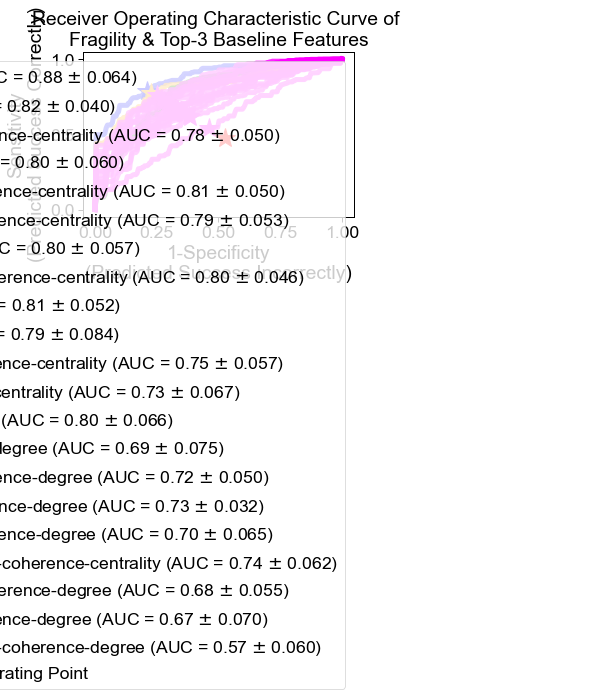

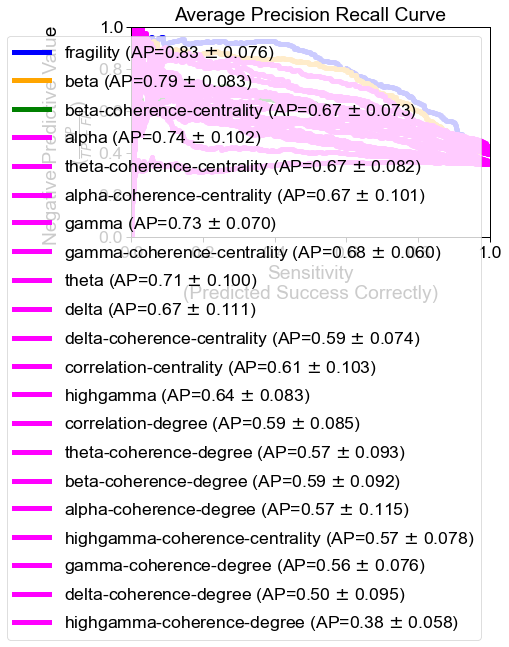

In [28]:
sns.set_context('paper', font_scale=2.0)
fig, ax = plt.subplots(1, 1, figsize=(7,7))
colors = ['blue', 'orange', 'green', 'magenta']

feature_aucs = dict()
feature_prs = dict()

feature_pred_names = []
feature_pred_probs = []
feature_pred_subs = []

# for idx, (feature_name, nested_scores) in enumerate(nested_scores_feature.items()):
for idx in range(len(auc_feat_names)):
    feature_name = np.asarray(auc_feat_names)[auc_sorted_inds][idx]
    
    if idx > 3:
        idx = 3
    color = colors[idx]
    
    nested_scores = nested_scores_feature[feature_name]
    color = colors[idx]

    pat_predict_proba = nested_scores['validate_pat_predictions']
    pat_true = nested_scores['validate_pat_true']
    fprs, tprs = nested_scores['validate_fpr'], nested_scores['validate_tpr']
    
    fprs = []
    tprs = []
    accs = []
    aps = []
    npvs = []
    ppvs = []
    ratio_succ = []
    ratio_fail = []
    n_succ = []
    n_fail = []

#     print(len(pat_true))
#     print(type(pat_true[1].item()))
    for jdx in range(len(pat_true)):
        if isinstance(pat_true[jdx], dict):
            pat_trues = pat_true[jdx]
            pat_predicts = pat_predict_proba[jdx]
        else:
            pat_trues = pat_true[jdx].item()
            pat_predicts = pat_predict_proba[jdx].item()

        pat_proba = []
        pat_y = []
        subjects = []
        for patient, pat_y_true in pat_trues.items():
            pat_probas = pat_predicts[patient]
            pat_mean_proba = np.mean(np.array(pat_probas).squeeze())

            pat_proba.append(pat_mean_proba)
            pat_y.append(pat_y_true)
            subjects.append(patient)
        pat_predictions = np.where(np.array(pat_proba) > 0.5, 1, 0)
        acc = balanced_accuracy_score(pat_y, pat_predictions)
#         print(acc)
        
        n_true_succ = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if ytrue_ == 1])
        n_true_fail = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if ytrue_ == 0])
        num_fail = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if y_ == ytrue_ if ytrue_ == 0])
        num_success = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if y_ == ytrue_ if ytrue_ == 1])
#         print(f'Number fail {num_fail} out of {n_true_fail}, and number success {num_success} out of {n_true_succ}')
        ratio_fail.append(num_fail / n_true_fail)
        ratio_succ.append(num_success / n_true_succ)
        n_fail.append(n_true_fail)
        n_succ.append(n_true_succ)
        
        sensitivity, specificity, pos_pred_val, neg_pred_val = perf_metrics_2X2(np.array(pat_y), np.array(pat_predictions))
        npvs.append(neg_pred_val)
        ppvs.append(pos_pred_val)
        
        average_precision = average_precision_score(pat_y, pat_proba, pos_label=0, average=None)
        aps.append(average_precision)
        
        # roc curve
        fpr, tpr, thresholds = roc_curve(pat_y, pat_proba)
        fprs.append(fpr)
        tprs.append(tpr)
        accs.append(acc)
        
        feature_pred_subs.extend(subjects)
        feature_pred_probs.extend(pat_proba)
        feature_pred_names.extend([feature_name] * len(pat_proba))

    mean_fpr, tprs, aucs = average_roc(fprs, tprs)
    mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)

    # avg/std of the AUC statistic
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    feature_aucs[feature_name] = aucs

    ax = _plot_roc_curve(mean_tpr, mean_fpr, 
#                          std_tpr=std_tpr, 
                         mean_auc=mean_auc, std_auc=std_auc, 
                         label=feature_name, ax=ax, color=color, 
                         plot_chance=False)

    # plot youden point
    xs, ys = create_line(clinical_fpr, 0, clinical_sensitivity, 1)
    youden_idx = find_intersect_idx(mean_fpr, mean_tpr, xs, ys)
    youden_point = (mean_fpr[youden_idx], mean_tpr[youden_idx])
    ax.plot(youden_point[0], youden_point[1], marker='*', color=color, markersize=20, 
            linestyle='None', 
           )
    
    ytrues, ypreds = nested_scores['validate_ytrue'], nested_scores['validate_ypred_prob']
    accs = []
    f1s = []
    for ytrue, ypred in zip(ytrues, ypreds):
        ytrue = np.array(ytrue).squeeze()
        ypred = np.array(ypred).squeeze()
        ypred = np.array(ypred) > 0.5
        acc = balanced_accuracy_score(ytrue, ypred)
        f1score = f1_score(ytrue, ypred)
        accs.append(acc)
        f1s.append(f1score)
    print(f'\n\n{feature_name}')
    print([params for params in nested_scores['hyperparameters']])
#     print(f'Balanced accuracy score: {np.mean(accs):.2f} +/- {np.std(accs):.2f}')
    print(f'Balanced accuracy score: {np.mean(accs):.2f} +/- {np.std(accs):.2f}')
    print(f'F1 score: {np.mean(f1s):.2f} +/- {np.std(f1s):.2f}')
    print(f'Sensitivity: {youden_point[1]} and FPR: {youden_point[0]}')
    print('Improvement in FPR: ', np.round(youden_point[0]-clinical_fpr, 2))
    print('Improvement in TPR: ', np.round(youden_point[1]-clinical_sensitivity, 2))
    print('Total distance: ', np.linalg.norm((youden_point[0]-clinical_fpr, youden_point[1]-clinical_sensitivity)))
    print(f'Average Preicions: {np.mean(aps):.3f} +/- {np.std(aps):.3f}')
    print(f'Average NPVS: {np.mean(npvs):.3f} +/- {np.std(npvs):.3f}')
    print(f'Average PPVS: {np.mean(ppvs):.3f} +/- {np.std(ppvs):.3f}')
    print(f'Average failed ratio: {np.mean(ratio_fail):.3f} +/- {np.std(ratio_fail):.3f}')    
    print(f'Average success ratio: {np.mean(ratio_succ):.3f} +/- {np.std(ratio_succ):.3f}')    
    
    if idx >= 0:
        ytrues, ypreds = nested_scores['validate_ytrue'], nested_scores['validate_ypred_prob']
        from sklearn.metrics import plot_precision_recall_curve, average_precision_score
        from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
        if idx == 0:
#             sns.set_context('paper', font_scale=1.5)
            pfig, pax = plt.subplots(figsize=(7,7))
        avg_prec = []
        y_real = []
        y_proba = []
        for ytrue, ypred in zip(ytrues, ypreds):
#             prec, recall, _ = precision_recall_curve(ytrue, ypred,
#                                                      pos_label=1)
#             disp = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax)

            average_precision = average_precision_score(ytrue, ypred, pos_label=1.,
                                                         average=None)
            avg_prec.append(average_precision)
            y_real.append(ytrue)
            y_proba.append(ypred)
        
        # store all the average precisions per feature
        feature_prs[feature_name] = avg_prec
            
        y_real = np.concatenate(y_real)
        y_proba = np.concatenate(y_proba)
        precision, recall, _ = precision_recall_curve(y_real, y_proba, pos_label=1)
#         lab = 'Overall Av=%.4f' % (auc(recall, precision))
        pax.step(recall, precision, lw=5, color=color, 
                label=f'{feature_name} (AP={np.mean(avg_prec):.2f} $\pm$ {np.std(avg_prec):.3f})')
        pax.set(title='Average Precision Recall Curve',
                xlim=[0, 1], ylim=[0, 1],
                xlabel='Sensitivity\n(Predicted Success Correctly)',
                ylabel='Negative Predictive Value \n'+ r'($\frac{TP}{TP+FP}$)'
                          )
#         pax.axhline(0.5, color='red', linestyle='--', label='Chance')
#         plt.show()

        
ax.set(
    ylabel='Sensitivity\n(Predicted Success Correctly)',
    xlabel='1-Specificity\n(Predicted Success Incorrectly)',
    title='Receiver Operating Characteristic Curve of \nFragility & Top-3 Baseline Features',
#     xlim=[0, 0.05],
#     ylim=[0.4, 1],
)
# plot clinical point
ax.plot(clinical_fpr, clinical_sensitivity, 
        marker='*', color='red', markersize=20, 
        linestyle='None',
        label='Clinical Operating Point')
ax.legend(
#     ncol=2,
#     loc=(1.04, 0)
          )
pax.legend()
fig.tight_layout()
pfig.tight_layout()
# pfig.savefig(figdir / f'figure4-discriminationandprecision/pr_curve_{clf_type}_quantilefeatures.pdf',
#            bbox_inches='tight')
# fig.savefig(figdir / f'figure4-discriminationandprecision/roc_curve_{clf_type}_quantilefeatures.pdf',
#            bbox_inches='tight')

## AUC

In [35]:
feature_aucs_df = pd.DataFrame.from_dict(feature_aucs)
feature_aucs_df['id_col'] = np.arange(10)

display(feature_aucs_df.head())
feature_aucs_df = pd.melt(feature_aucs_df, id_vars='id_col',
                          var_name='feature', value_name='auc')
# display  
feature_aucs_df.columns = [x.capitalize() if x in ['feature'] else x.upper() for x in feature_aucs_df.columns ]
feature_aucs_df['Feature'] = feature_aucs_df['Feature'].str.capitalize() 
display(feature_aucs_df.head())

,fragility,beta,beta-coherence-centrality,alpha,theta-coherence-centrality,alpha-coherence-centrality,gamma,gamma-coherence-centrality,theta,delta,...,highgamma,correlation-degree,theta-coherence-degree,beta-coherence-degree,alpha-coherence-degree,highgamma-coherence-centrality,gamma-coherence-degree,delta-coherence-degree,highgamma-coherence-degree,id_col
0,0.937186,0.788751,0.825860,0.718013,0.764979,0.824608,0.844801,0.792424,0.825087,0.808852,...,0.839776,0.692501,0.664090,0.778701,0.724386,0.681678,0.672594,0.694434,0.570932,0
1,0.769203,0.734027,0.720669,0.799354,0.798667,0.749727,0.667265,0.758466,0.759512,0.790380,...,0.711043,0.693467,0.737854,0.701005,0.653157,0.742080,0.779222,0.662971,0.539983,1
2,0.967337,0.886217,0.789630,0.900933,0.829146,0.711425,0.891601,0.823892,0.880833,0.911701,...,0.891960,0.876167,0.689127,0.721823,0.653723,0.760164,0.642988,0.619461,0.594564,2
3,0.885858,0.835607,0.825104,0.754128,0.904915,0.886935,0.789304,0.833625,0.759153,0.709261,...,0.774587,0.683776,0.691392,0.785777,0.764802,0.836246,0.735726,0.694173,0.581084,3
4,0.954495,0.798995,0.781686,0.882189,0.777499,0.778894,0.799553,0.848409,0.864880,0.887772,...,0.915690,0.617253,0.712172,0.715243,0.711055,0.755165,0.668621,0.702401,0.658571,4


,ID_COL,Feature,AUC
0,0,Fragility,0.937186
1,1,Fragility,0.769203
2,2,Fragility,0.967337
3,3,Fragility,0.885858
4,4,Fragility,0.954495


In [36]:
# map feature names to short-hand
feature_aucs_df['Feature'] = [x.replace('coherence', 'coh').
                          replace('degree', 'deg').
                          replace('centrality', 'cent').
                          replace('Correlation', 'Corr') for x in feature_aucs_df['Feature']]

order = feature_aucs_df.groupby('Feature').median().sort_values(by='AUC', ascending=False)
print(order.index)
print(len(order))

Index(['Fragility', 'Beta', 'Gamma-coh-cent', 'Theta-coh-cent', 'Delta',
       'Gamma', 'Theta', 'Highgamma', 'Beta-coh-cent', 'Alpha',
       'Alpha-coh-cent', 'Corr-cent', 'Highgamma-coh-cent', 'Delta-coh-cent',
       'Beta-coh-deg', 'Alpha-coh-deg', 'Theta-coh-deg', 'Corr-deg',
       'Delta-coh-deg', 'Gamma-coh-deg', 'Highgamma-coh-deg'],
      dtype='object', name='Feature')
21


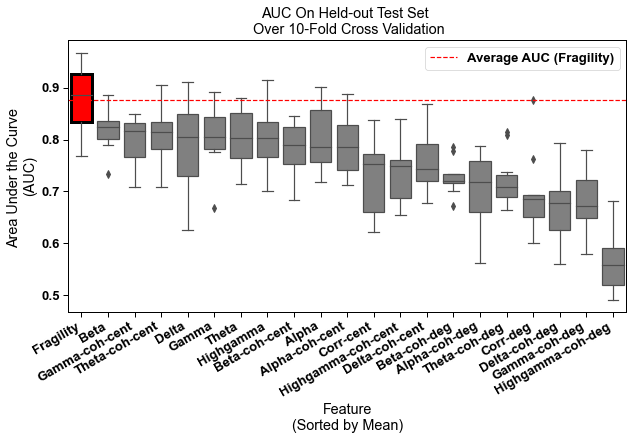

In [37]:
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

sns.set_context('paper', font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='Feature', y='AUC', order=order.index,
            data=feature_aucs_df, ax=ax,
           color='gray')
ax.axhline(feature_aucs_df[feature_aucs_df['Feature'] == 'Fragility']['AUC'].mean(),
          color='red', ls='--', label='Average AUC (Fragility)')
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, 
                   ha='right', rotation=30
                  )
ax.legend()
ax.set(title='AUC On Held-out Test Set \n Over 10-Fold Cross Validation',
      xlabel='Feature\n(Sorted by Mean)',
      ylabel='Area Under the Curve \n(AUC)')

# Select which box you want to change    
mybox = ax.artists[0]

# Change the appearance of that box
mybox.set_facecolor('red')
mybox.set_edgecolor('black')
mybox.set_linewidth(3)

figpath = Path(figdir) / f'figure4-discriminationandprecision/'
fname = f'delta_auc_plot_{clf_type}_quantilefeatures.pdf'
# fig.savefig(figpath / fname, bbox_inches='tight')


In [38]:
feature_aucs_dabest = dabest.load(feature_aucs_df, 
                                  x='Feature', y='AUC', 
                                  paired=True, 
                                  id_col='ID_COL',
                                  idx=('Fragility', 'Beta', 
#                                        ['fragility', 'alpha']
                                      ),
#                                   idx=feature_aucs_df['Feature'].unique(), 
                                  ci=95)
feature_aucs_dabest.cohens_d

display(feature_aucs_dabest.cohens_d.results)
display(feature_aucs_dabest.cohens_d.results)
display(feature_aucs_dabest.cohens_d.lqrt)

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,pct_interval_idx,bootstraps,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Fragility,Beta,10,10,Cohen's d,True,-0.975727,95,-1.971765,-0.292071,...,"(125, 4875)","[-4.023742575508326, -3.7709889186620043, -3.5...",5000,12345,0.0204,5000,0.027344,6.0,0.02255,2.748023


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,pct_interval_idx,bootstraps,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Fragility,Beta,10,10,Cohen's d,True,-0.975727,95,-1.971765,-0.292071,...,"(125, 4875)","[-4.023742575508326, -3.7709889186620043, -3.5...",5000,12345,0.0204,5000,0.027344,6.0,0.02255,2.748023


,control,test,control_N,test_N,pvalue_paired_lqrt,statistic_paired_lqrt
0,Fragility,Beta,10,10,0.23,12.559138


done


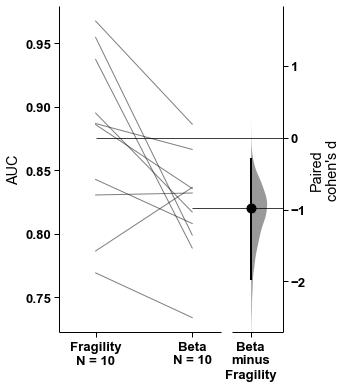

In [25]:
plt.rcParams['font.weight'] = 'bold'
sns.set_context('paper', font_scale=1.5)
fig, ax = plt.subplots(figsize=(4,6))
feature_aucs_dabest.cohens_d.plot(ax=ax)
figpath = Path(figdir) / 'discrimination_and_calibration/'
figname = f'paired_estimationplot_fragilityvsbeta_{clf_type}_quantilefeatures.pdf'
# ax.set(title="Paired Estimation Plots of \nCohen's D Effect Size Difference in AUC")
# fig.savefig(figpath / figname, 
#             bbox_inches='tight')
print('done')

## PR

In [39]:
feature_prs_df = pd.DataFrame.from_dict(feature_prs)
feature_prs_df['id_col'] = np.arange(10)

display(feature_prs_df.head())
feature_prs_df = pd.melt(feature_prs_df, id_vars='id_col',
                          var_name='feature', value_name='pr')
# display  
feature_prs_df.columns = [x.capitalize() if x in ['feature'] else x.upper() for x in feature_prs_df.columns]
feature_prs_df['Feature'] = feature_prs_df['Feature'].str.capitalize() 
display(feature_prs_df.head())

,fragility,beta,beta-coherence-centrality,alpha,theta-coherence-centrality,alpha-coherence-centrality,gamma,gamma-coherence-centrality,theta,delta,...,highgamma,correlation-degree,theta-coherence-degree,beta-coherence-degree,alpha-coherence-degree,highgamma-coherence-centrality,gamma-coherence-degree,delta-coherence-degree,highgamma-coherence-degree,id_col
0,0.881700,0.744085,0.786770,0.645399,0.745643,0.829614,0.786200,0.702064,0.709527,0.750803,...,0.784641,0.634391,0.571361,0.747668,0.748044,0.564413,0.613117,0.597503,0.438061,0
1,0.811345,0.799917,0.556219,0.820918,0.651236,0.596016,0.634245,0.577553,0.710997,0.762914,...,0.624270,0.603411,0.528985,0.468861,0.393556,0.607843,0.599147,0.453369,0.316716,1
2,0.926832,0.791390,0.652873,0.685981,0.650260,0.485659,0.761725,0.655964,0.592648,0.680459,...,0.665391,0.680691,0.482877,0.580109,0.454163,0.454897,0.474202,0.435401,0.282967,2
3,0.871919,0.829193,0.716134,0.756491,0.766109,0.763605,0.809842,0.756501,0.758633,0.642993,...,0.610416,0.639232,0.616634,0.711090,0.634498,0.685202,0.651732,0.506057,0.415766,3
4,0.952883,0.912915,0.556065,0.942254,0.537133,0.584119,0.837599,0.653731,0.911983,0.848509,...,0.771918,0.644851,0.379599,0.512387,0.559755,0.529328,0.479157,0.367219,0.338060,4


,ID_COL,Feature,PR
0,0,Fragility,0.881700
1,1,Fragility,0.811345
2,2,Fragility,0.926832
3,3,Fragility,0.871919
4,4,Fragility,0.952883


In [42]:
# map feature names to short-hand
feature_prs_df['Feature'] = [x.replace('coherence', 'coh').
                          replace('degree', 'deg').
                          replace('centrality', 'cent').
                          replace('Correlation', 'Corr') for x in feature_prs_df['Feature']]
display(feature_prs_df.head())

,ID_COL,Feature,PR
4,4,Fragility,0.952883
34,4,Alpha,0.942254
2,2,Fragility,0.926832
14,4,Beta,0.912915
84,4,Theta,0.911983


In [43]:
feature_prs_df = feature_prs_df.sort_values(by='PR', ascending=False)
order = feature_prs_df.groupby('Feature').median().sort_values(by='PR', ascending=False)
print(order.index)

Index(['Fragility', 'Beta', 'Alpha', 'Gamma', 'Theta', 'Alpha-coh-cent',
       'Gamma-coh-cent', 'Theta-coh-cent', 'Delta', 'Beta-coh-cent',
       'Corr-cent', 'Highgamma', 'Corr-deg', 'Alpha-coh-deg', 'Delta-coh-cent',
       'Beta-coh-deg', 'Gamma-coh-deg', 'Highgamma-coh-cent', 'Theta-coh-deg',
       'Delta-coh-deg', 'Highgamma-coh-deg'],
      dtype='object', name='Feature')


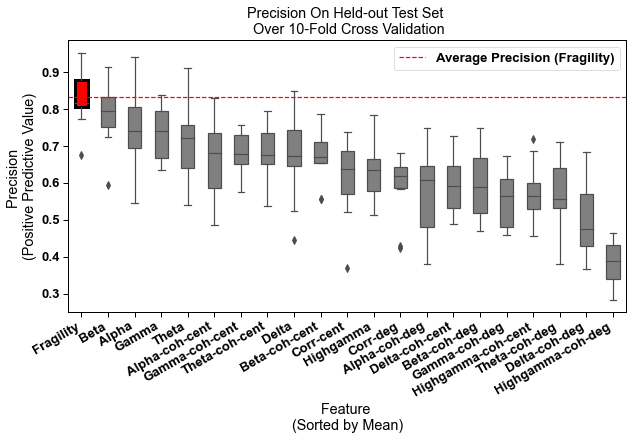

In [44]:
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

sns.set_context('paper', font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='Feature', y='PR', color='gray', order=order.index,
            data=feature_prs_df, ax=ax, width=0.5)
ax.axhline(feature_prs_df[feature_prs_df['Feature']=='Fragility']['PR'].mean(), 
           color='red', ls='--', label='Average Precision (Fragility)')
ax.legend()

xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, 
                   ha='right', rotation=30
                  )
ax.set(title='Precision On Held-out Test Set \n Over 10-Fold Cross Validation',
      ylabel='Precision \n(Positive Predictive Value)',
      xlabel='Feature \n(Sorted by Mean)')
# Select which box you want to change    
mybox = ax.artists[0]

# Change the appearance of that box
mybox.set_facecolor('red')
mybox.set_edgecolor('black')
mybox.set_linewidth(3)

figpath = Path(figdir) / f'figure4-discriminationandprecision/'
fname = f'delta_precision_plot_{clf_type}_quantilefeatures.pdf'
# fig.savefig(figpath / fname, bbox_inches='tight')


## Compute Effect Size and P-Value For all Features

In [45]:
feature_df = pd.DataFrame(np.vstack([feature_pred_names, feature_pred_probs, feature_pred_subs]).T, columns=['name', 'proba', 'subject'])

outcomes = []
pat_df = read_clinical_excel(excel_fpath, keep_as_df=True)
display(pat_df.head())
for subj in feature_df['subject']:
    # use excel file to set various data points
    pat_row = pat_df[pat_df['PATIENT_ID'] == subj.upper()]
#     print(pat_row)
    outcomes.append(pat_row['OUTCOME'].values[0])

feature_df['outcome'] = outcomes
feature_df['proba'] = pd.to_numeric(feature_df['proba'])

display(feature_df.head())

,JOURNAL_PATIENTID,PATIENT_ID,NUMBER_DATASETS,CLINICAL_CENTER,MODALITY,SFREQ,PREVIOUS SURGERY?,CLINICAL_COMPLEXITY,ENGEL_SCORE,ILAE_SCORE,...,DATE/YEAR OF SURGERY,DATE_LAST_FOLLOW_UP,YEARS_FOLLOW_UP,NOTES,PREVIOUS - FOLLOWUP,UNNAMED: 39,UNNAMED: 40,UNNAMED: 41,UNNAMED: 42,UNNAMED: 43
0,PATIENT_1,PT1,4.0,NIH,ECOG,1000.0,n/a,1.0,1.0,2.0,...,NAT,2019-05-15,3.0,n/a,2017-04-26,n/a,n/a,n/a,n/a,n/a
1,PATIENT_2,PT2,3.0,NIH,ECOG,1000.0,n/a,1.0,1.0,1.0,...,NAT,2020-01-16,3.0,n/a,2017-03-16,n/a,n/a,n/a,n/a,n/a
2,PATIENT_3,PT3,2.0,NIH,ECOG,1000.0,n/a,3.0,1.0,1.0,...,NAT,2017-03-02,2.0,n/a,2017-03-02,n/a,n/a,n/a,n/a,n/a
3,PATIENT_4,PT6,3.0,NIH,ECOG,1000.0,n/a,4.0,2.0,5.0,...,NAT,2019-01-03,3.0,n/a,2016-12-09,n/a,n/a,n/a,n/a,n/a
4,PATIENT_5,PT7,3.0,NIH,ECOG,1000.0,n/a,3.0,3.0,1.0,...,NAT,2020-02-14,7.0,n/a,2017-04-26,n/a,n/a,n/a,n/a,n/a


,name,proba,subject,outcome
0,fragility,0.180500,jh101,F
1,fragility,0.110000,jh103,F
2,fragility,0.386800,jh105,S
3,fragility,0.194000,la01,F
4,fragility,0.177333,la12,F


In [46]:
names = []
effs = []
effs_ublb = []
pvals_mw = []
pvals_lqrt = []
results_list = []

for name in feature_df['name'].unique():
    # create dabest and run effect size and pvalue computation
    feat_dabest = dabest.load(feature_df[feature_df['name'] == name], 
                              x='outcome', y='proba',
                             idx=('F', 'S'),
#                               ci=0.67
                             )
    
    results = feat_dabest.cohens_d.results
    
    effs.append(results['difference'].values[0])
    effs_ublb.append([results['bca_low'].values[0], results['bca_high'].values[0]])
    pvals_mw.append(results['pvalue_mann_whitney'].values[0])
    pvals_lqrt.append(feat_dabest.cohens_d.lqrt['pvalue_lqrt_unequal_var'].values[0])
    names.append(name)
    
    results_list.append(results)
    
    print(name)
    display(feat_dabest.cohens_d.results)
#     break

fragility


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,180,190,Cohen's d,False,1.506628,95,1.233035,1.762851,...,5000,12345,0.0,5000,4.333439e-38,-14.572384,6.074498e-38,-14.484995,6.747815e-31,5215.0


beta


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,180,190,Cohen's d,False,1.275521,95,1.024152,1.516,...,5000,12345,0.0,5000,2.248470e-29,-12.343579,3.197644e-29,-12.263088,4.830695e-25,6471.0


beta-coherence-centrality


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,231,229,Cohen's d,False,0.882543,95,0.66884,1.092901,...,5000,12345,0.0,5000,1.561252e-19,-9.468169,1.567788e-19,-9.464124,3.214823e-19,13674.5


alpha


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,180,190,Cohen's d,False,1.173808,95,0.937585,1.427802,...,5000,12345,0.0,5000,1.013818e-25,-11.35496,1.450638e-25,-11.285205,4.485415e-22,7167.0


theta-coherence-centrality


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,231,229,Cohen's d,False,1.046824,95,0.827972,1.2741,...,5000,12345,0.0,5000,5.286140e-26,-11.227136,5.336816e-26,-11.225827,1.201889e-23,12160.0


alpha-coherence-centrality


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,231,229,Cohen's d,False,0.929903,95,0.730492,1.13661,...,5000,12345,0.0,5000,2.515422e-21,-9.976551,2.511963e-21,-9.972003,1.051329e-19,13500.0


gamma


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,180,190,Cohen's d,False,1.158356,95,0.939773,1.37813,...,5000,12345,0.0,5000,3.552429e-25,-11.201168,5.069013e-25,-11.136646,1.315527e-21,7281.0


gamma-coherence-centrality


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,231,229,Cohen's d,False,0.93441,95,0.723593,1.144021,...,5000,12345,0.0,5000,1.694322e-21,-10.019769,1.683065e-21,-10.020331,2.363727e-20,13270.5


theta


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,180,190,Cohen's d,False,1.168943,95,0.936027,1.407824,...,5000,12345,0.0,5000,1.508422e-25,-11.301332,2.152821e-25,-11.23843,1.547306e-22,7055.5


delta


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,180,190,Cohen's d,False,1.090068,95,0.85966,1.313424,...,5000,12345,0.0,5000,1.007216e-22,-10.497168,1.157176e-22,-10.480106,1.147574e-20,7514.5


delta-coherence-centrality


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,231,229,Cohen's d,False,0.73204,95,0.539021,0.931464,...,5000,12345,0.0,5000,2.947727e-14,-7.854112,2.968958e-14,-7.850177,1.015466e-13,15844.5


correlation-centrality


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,231,229,Cohen's d,False,0.695388,95,0.510763,0.886394,...,5000,12345,0.0,5000,4.911201e-13,-7.45119,4.465848e-13,-7.457136,1.070659e-12,16297.5


highgamma


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,180,190,Cohen's d,False,1.021711,95,0.787196,1.262292,...,5000,12345,0.0,5000,2.295895e-20,-9.821303,2.228581e-20,-9.822909,2.989485e-20,7619.5


correlation-degree


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,180,190,Cohen's d,False,0.589593,95,0.379298,0.799801,...,5000,12345,0.0,5000,2.843631e-08,-5.673101,2.914303e-08,-5.668456,1.309852e-08,11254.0


theta-coherence-degree


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,231,229,Cohen's d,False,0.642814,95,0.451886,0.827049,...,5000,12345,0.0,5000,1.970932e-11,-6.887515,1.813380e-11,-6.893352,1.936252e-10,17373.5


beta-coherence-degree


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,231,229,Cohen's d,False,0.681141,95,0.486683,0.873386,...,5000,12345,0.0,5000,1.404906e-12,-7.297286,1.245428e-12,-7.304349,1.446445e-11,16822.0


alpha-coherence-degree


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,231,229,Cohen's d,False,0.607318,95,0.421902,0.793216,...,5000,12345,0.0,5000,2.039098e-10,-6.508557,1.945441e-10,-6.512699,2.574766e-09,17957.5


highgamma-coherence-centrality


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,231,229,Cohen's d,False,0.661877,95,0.476373,0.854456,...,5000,12345,0.0,5000,5.201076e-12,-7.092793,4.857352e-12,-7.097773,1.394857e-11,16814.5


gamma-coherence-degree


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,231,229,Cohen's d,False,0.630863,95,0.441201,0.806523,...,5000,12345,0.0,5000,4.476742e-11,-6.758805,4.079043e-11,-6.765188,3.202486e-09,18008.5


delta-coherence-degree


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,231,229,Cohen's d,False,0.429173,95,0.249199,0.604515,...,5000,12345,0.0,5000,0.000005,-4.60111,0.000005,-4.602319,0.000021,20380.5


highgamma-coherence-degree


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,F,S,231,229,Cohen's d,False,0.104929,95,-0.078489,0.28548,...,5000,12345,0.2562,5000,0.26134,-1.124642,0.261083,-1.125225,0.527592,25548.5


In [47]:
print(feat_dabest.cohens_d.results.columns)

Index(['control', 'test', 'control_N', 'test_N', 'effect_size', 'is_paired',
       'difference', 'ci', 'bca_low', 'bca_high', 'bca_interval_idx',
       'pct_low', 'pct_high', 'pct_interval_idx', 'bootstraps', 'resamples',
       'random_seed', 'pvalue_permutation', 'permutation_count',
       'pvalue_welch', 'statistic_welch', 'pvalue_students_t',
       'statistic_students_t', 'pvalue_mann_whitney',
       'statistic_mann_whitney'],
      dtype='object')


In [48]:
# map feature names to short-hand
names = [x.replace('coherence', 'coh').
                          replace('degree', 'deg').
                          replace('centrality', 'cent').
                          replace('correlation', 'corr').capitalize() for x in names]

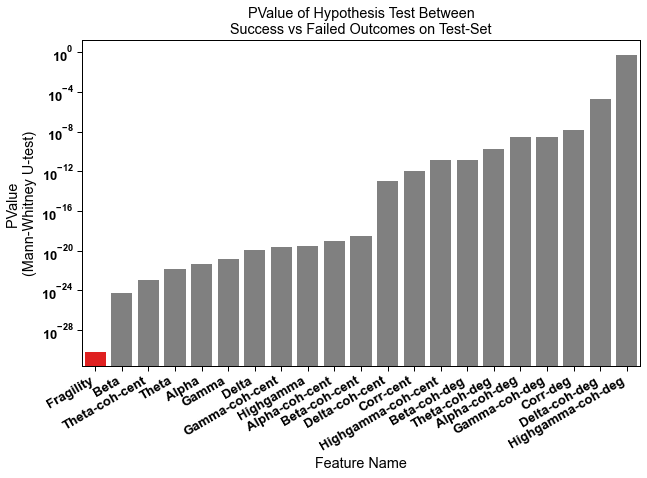

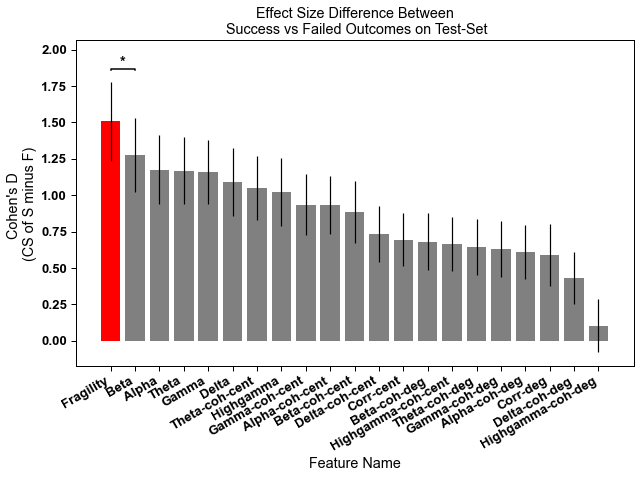

In [51]:
# create bar plot of the effect size and pvalue
ub = np.array(effs_ublb)[:, 0]
lb = np.array(effs_ublb)[:, 1]
outcome_df = pd.DataFrame((names, effs, ub, lb, pvals_mw, pvals_lqrt
                                    )).T
outcome_df.columns=['name', 'es', 'es_ub', 'es_lb', 'pval_mw', 'pval_lqrt']

yerr = np.vstack((outcome_df['es_lb'] - outcome_df['es'],
                  outcome_df['es_ub'] - outcome_df['es']))

figsize = (10, 6)

############################ create bar plot for pvalues ############################
colors = ['gray'] * len(order)
colors[0] = 'red'
fig, ax = plt.subplots(figsize=figsize)
order = outcome_df['pval_mw'].argsort()
sns.barplot(x='name', y='pval_mw', 
            palette=colors, order=outcome_df['name'][order],
            data=outcome_df, ax=ax)
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set(title='PValue of Hypothesis Test Between\nSuccess vs Failed Outcomes on Test-Set',
      xlabel='Feature Name', ylabel='PValue \n(Mann-Whitney U-test)')

figpath = Path(figdir) / f'figure4-discriminationandprecision/'
figname = f'pvals_svsf_{clf_type}_quantilefeatures.pdf'
fig.savefig(figpath / figname, 
            bbox_inches='tight')


# get the hypothesis test for outcome 'es' for fragility vs beta
frag_results, beta_results = results_list[0], results_list[1]
scipy.stats.wilcoxon(frag_results.bootstraps.values[0], beta_results.bootstraps.values[0])

############################ create bar plot for es ############################
order = outcome_df['es'].argsort()[::-1]
colors = ['gray'] * len(order)
colors[0] = 'red'
fig, ax = plt.subplots(figsize=figsize)
ax.bar(x=np.arange(len(outcome_df['name'].unique())), tick_label=outcome_df['name'][order], 
       height=outcome_df['es'][order].tolist(), 
       yerr=yerr[1,order], color=colors)
ax.set(title="Effect Size Difference Between\n Success vs Failed Outcomes on Test-Set",
      xlabel='Feature Name', 
       ylabel="Cohen's D \n(CS of S minus F)")
# statistical annotation
x1, x2 = 0, 1 # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = outcome_df['es'].max() + 0.35, 0.01, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h/2.5, "*", ha='center', va='bottom', color=col)
ylim = ax.get_ylim()
ax.set_ylim([ylim[0], ylim[1]+0.1])

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
figpath = Path(figdir) / f'figure4-discriminationandprecision/'
figname = f'es_svsf_{clf_type}_quantilefeatures.pdf'
fig.savefig(figpath / figname, 
            bbox_inches='tight')



# Calibration Curve

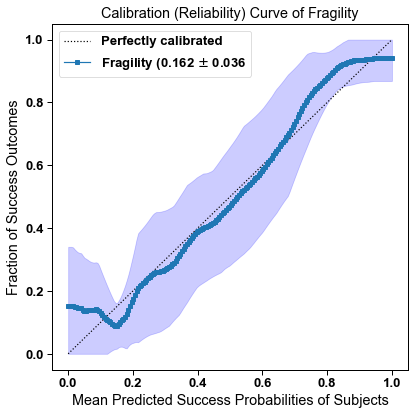

done


In [35]:
#
plt.rcParams['font.weight'] = 'bold'
sns.set_context("paper", font_scale=1.5)
# plt.figure(figsize=(6,6))

# ax1 = plt.subplot2grid((2, 1), (0, 0), rowspan=1)
fig, ax1 = plt.subplots(figsize=(6,6))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

colors = ['blue', 'orange', 'green', 'magenta']
for idx in range(1):
    name = np.asarray(auc_feat_names)[auc_sorted_inds][idx]
    color = colors[idx]
    
    nested_scores = nested_scores_feature[name]

    y_predict_prob = nested_scores['validate_ypred_prob']
    y_trues = nested_scores['validate_ytrue']


    frac_pred_vals = []
    mean_pred_values = np.linspace(0, 1.0, 200)
    brier_scores = []
    for i, (y, prob_pos) in enumerate(zip(y_trues, y_predict_prob)):
        prob_pos = np.array(prob_pos)#[:, 1]
        # compute calibration curve
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y, prob_pos, n_bins=10, strategy="quantile"
        )

        clf_score = np.round(
            brier_score_loss(y, prob_pos, pos_label=np.array(y).max()), 3
        )

        # create a linear interpolation of the calibration
        interp_frac_positives = np.interp(
            mean_pred_values, mean_predicted_value, fraction_of_positives
        )
#         interp_frac_positives[0] = 0.0

        # store curves + scores
        brier_scores.append(clf_score)
        frac_pred_vals.append(interp_frac_positives)

    mean_frac_pred_values = np.mean(frac_pred_vals, axis=0)
    ax1.plot(
        mean_pred_values,
        mean_frac_pred_values,
        "s-",
        label=rf"{name.capitalize()} ({np.round(np.mean(brier_scores),3)} $\pm$ {np.round(np.std(brier_scores), 3)}",
    )

    # get upper and lower bound for tpr
    std_fpv = np.std(frac_pred_vals, axis=0)
    tprs_upper = np.minimum(mean_frac_pred_values + std_fpv, 1)
    tprs_lower = np.maximum(mean_frac_pred_values - std_fpv, 0)
    ax1.fill_between(
        mean_pred_values,
        tprs_lower,
        tprs_upper,
        color=color,
        alpha=0.2,
        # label=r"$\pm$ 1 std. dev.",
    )

# ax1.plot()
ax1.set(
    ylabel="Fraction of Success Outcomes",
    ylim=[-0.05, 1.05],
    xlabel='Mean Predicted Success Probabilities of Subjects'
)

ax1.legend(
#     loc=(1.04, 0)
          )
ax1.set_title("Calibration (Reliability) Curve of Fragility")

plt.tight_layout()
figpath = Path(figdir) / f'discrimination_and_calibration/'
fname = f'calibration_curve_{clf_type}_quantilefeatures.pdf'
# fig.savefig(figpath / fname, bbox_inches='tight')
plt.show()
print('done')

# Feature Permutations for Importances over the Spatiotemporal Heatmap

In [36]:
# number of quantiles used
IMAGE_HEIGHT = 20

(2100,)
(2100,)
(2100,)
(2100,)
(2100,)
(2100,)
(2100,)
(2100,)
(2100,)
(2100,)


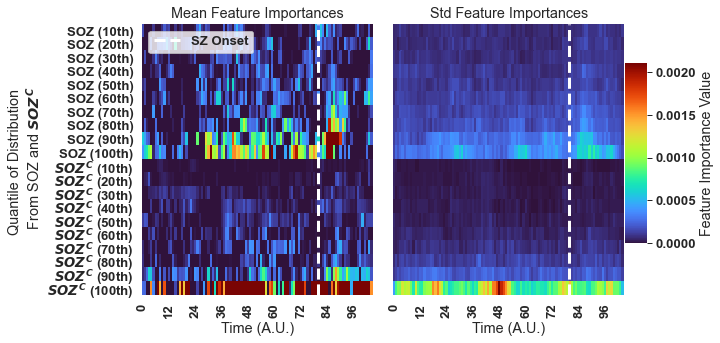

In [37]:
colors = ['blue', 'orange', 'green', 'magenta']

# loop over top 4
for idx in range(4):
    feature_name = np.asarray(auc_feat_names)[auc_sorted_inds][idx]
    color = colors[idx]
    
    nested_scores = nested_scores_feature[feature_name]
    color = colors[idx]

    imp_vals = []
    imp_std = []
    for cv_index in range(len(nested_scores['validate_imp_mean'])):
        _imp_vals = np.array(nested_scores['validate_imp_mean'][cv_index])
        _imp_std = np.array(nested_scores['validate_imp_std'][cv_index])

        print(_imp_vals.shape)
        best_window = nested_scores['hyperparameters'][cv_index][0]
        onsetwin = np.abs(best_window[0])

        X_shape = (IMAGE_HEIGHT, np.abs(best_window).sum())
        
        imp_vals.append(_imp_vals)
        imp_std.append(_imp_std)
        
    # average over the cross-validation folds
    imp_vals = np.mean(imp_vals, axis=0)
    imp_std = np.mean(imp_std, axis=0)
        
    # do a heatmap
    sns.set_context("paper", font_scale=1.5)
    sns.set_style("whitegrid", {'axes.grid' : False})
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), 
#                             sharey=True 
                           )
    cbar_ax = fig.add_axes([.88, .3, .03, .5])
    ax = axs[0]
    vmax=np.quantile(np.vstack((imp_vals.flatten(), imp_std.flatten())), 0.95)
    # vmax = np.quantile(imp_vals.flatten(), 0.95),
#     yticklabels = [
#         rf'$\mu$(SOZ)', r'$\sigma$(SOZ)', 
#                                   r'$\mu$($SOZ^C$)', r'$\sigma$($SOZ^C$)'
#     ]
    yticklabels = [f'SOZ ({idx*10}th)' for idx in range(1, 11)] + [f'$SOZ^C$ ({idx*10}th)' for idx in range(1, 11)] 
    
    ax = sns.heatmap(imp_vals.reshape(X_shape), vmax=vmax, vmin=0,
    #                  norm=LogNorm(imp_vals.min(),imp_vals.max()), 
                     yticklabels=yticklabels,
                     cmap='turbo', 
                     ax=ax,
                    cbar_ax=None, cbar=False,
                    )
    ax.set(title=f'Mean Feature Importances',# for {feature_name.capitalize()}",
           ylabel='Quantile of Distribution \n From SOZ and $SOZ^C$', 
           xlabel='Time (A.U.)')
    ax.axvline(onsetwin, lw=3, ls='--', color='white', label='SZ Onset')
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2])
#     ax.set_xticklabels(ax.get_xticklabels()[::2], 
#                        rotation=45
#                       )
    # for label in ax.xaxis.get_ticklabels()[::2]:
    #     label.set_visible(False)
    ax.legend()

    ax = axs[1]
    # vmax=np.quantile(imp_std.flatten(), 0.95),
    ax = sns.heatmap(imp_std.reshape(X_shape),  
    #                  vmax=vmax, vmin=0,
    #                  norm=LogNorm(imp_std.min(),imp_std.max()),  
    #                  yticklabels=[rf'$\mu$(SOZ)', r'$\sigma$(SOZ)', 
    #                               r'$\mu$($SOZ^C$)', r'$\sigma$($SOZ^C$)'],
                     cmap='turbo', ax=ax,
                     cbar=True, 
                     cbar_kws={'label': 'Feature Importance Value'},
                     cbar_ax=cbar_ax)
    ax.set(title="Std Feature Importances",
    #        ylabel='Feature(s) \nFrom SOZ and nSOZ', 
           yticks=[],
           xlabel='Time (A.U.)')
    
    ax.axvline(onsetwin, lw=3, ls='--', color='white', label='SZ Onset')
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2])
#     cbar_ax.set_title('Feature Importance Value')
#     cbar = fig.colorbar(, ax=axs.ravel().tolist(), shrink=0.95)
#     cbar.set_title('Feature Importance Value')
#     cbar.set_ticks(np.arange(0, 1.1, 0.5))
#     cbar.set_ticklabels(['low', 'medium', 'high'])

#     ax.set_xticklabels(ax.get_xticklabels()[::2], 
#                        rotation=45
#                       )
    # axs[1].set_yticks([])
    # for label in ax.xaxis.get_ticklabels()[::2]:
    #     label.set_visible(False)
#     ax.legend()
    fig.tight_layout(rect=[0, 0, .9, 1])
#     fig.tight_layout()
    figpath = figdir / 'feature_importances'
    figpath.mkdir(parents=True, exist_ok=True)
#     fig.savefig(figpath / f'{feature_name}-feature_importances-fixedwindow-20quantilefeatures-window-80to25.pdf', 
#                 bbox_inches='tight')
    break


# Analysis of the Prediction Probabilities Stratified By Clinical Variable (Clinical Complexity, Engel, ILAE)

In [38]:
pat_df = read_clinical_excel(excel_fpath, keep_as_df=True)

,CS,CC,ILAE,ENGEL,cv_index
0,0.122,4,6,4,0
1,0.168,4,6,4,0
2,0.258,4,6,4,0
3,0.174,4,6,4,0
4,0.192,3,6,4,0
...,...,...,...,...,...
1698,0.820,2,2,1,9
1699,0.840,2,2,1,9
1700,0.462,1,1,1,9
1701,0.566,1,1,1,9


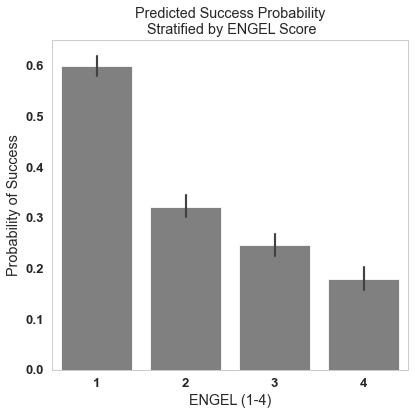

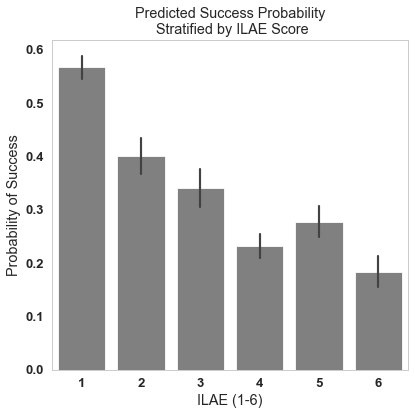

In [39]:
colors = ['blue', 'orange', 'green', 'magenta']

feature_aucs = dict()

# for idx, (feature_name, nested_scores) in enumerate(nested_scores_feature.items()):
for idx in range(4):
    feature_name = np.asarray(auc_feat_names)[auc_sorted_inds][idx]
    color = colors[idx]
    
    nested_scores = nested_scores_feature[feature_name]
    color = colors[idx]

    predict_probas = nested_scores['validate_ypred_prob']
    ytrues = nested_scores['validate_ytrue']
    subjects = nested_scores['validate_subjects']
    
    y_probs = []
    cc_scores = []
    ilae_scores = []
    engel_scores = [] #collections.defaultdict(list)
    cv_indices = []
    
    for jdx in range(len(ytrues)):
        for kdx, (y_proba, y, subject) in enumerate(zip(predict_probas[jdx], 
                                                        ytrues[jdx], 
                                                        subjects[jdx])):
            # use excel file to set various data points
            pat_row = pat_df[pat_df['PATIENT_ID'] == subject.upper()]
            cc = pat_row['CLINICAL_COMPLEXITY'].values[0]
            ilae = pat_row['ILAE_SCORE'].values[0]
            engel = pat_row['ENGEL_SCORE'].values[0]

            y_probs.append(y_proba)
            cc_scores.append(cc)
            ilae_scores.append(ilae)
            engel_scores.append(engel)
            cv_indices.append(jdx)

    cc_df = pd.DataFrame(np.vstack((y_probs, cc_scores, ilae_scores, engel_scores, cv_indices)).T, 
                         columns=('CS', 'CC', 'ILAE', 'ENGEL', 'cv_index'))
#     cc_df = pd.to_numeric(cc_df)
    cc_df = cc_df.apply(pd.to_numeric)
    cc_df[['CC', 'ILAE', 'ENGEL']] = cc_df[['CC', 'ILAE', 'ENGEL']].astype(int)
    display(cc_df)
    
    covname = 'ENGEL'
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["figure.titleweight"] = "bold"
    sns.set_context('paper', font_scale=1.5)
#     plt.rc("figure.title", labelweight="bold")
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
    sns.barplot(x=covname, y='CS', data=cc_df, ax=ax, color='gray')
    ax.set(
        ylabel='Probability of Success',
        xlabel=f'{covname.upper()} (1-4)',
        title=f'Predicted Success Probability\n Stratified by {covname.upper()} Score'
    )
    fig.tight_layout()
    figpath = figdir / 'cc_stratified'
    figpath = Path(figdir) / f'figure5-clinical_covariates/'

    figpath.mkdir(exist_ok=True)
#     fig.savefig(figpath / f'{feature_name}_{covname}_stratified_barplot.pdf')
    
    covname = 'ILAE'
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["figure.titleweight"] = "bold"
    sns.set_context('paper', font_scale=1.5)
#     plt.rc("figure.title", labelweight="bold")
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
    sns.barplot(x=covname, y='CS', data=cc_df, ax=ax, color='gray')
    ax.set(
        ylabel='Probability of Success',
        xlabel=f'{covname.upper()} (1-6)',
        title=f'Predicted Success Probability\n Stratified by {covname.upper()} Score'
    )
    fig.tight_layout()
    figpath = figdir / 'cc_stratified'
    figpath = Path(figdir) / f'figure5-clinical_covariates/'

    figpath.mkdir(exist_ok=True)
#     fig.savefig(figpath / f'{feature_name}_{covname}_stratified_barplot.pdf')
    break

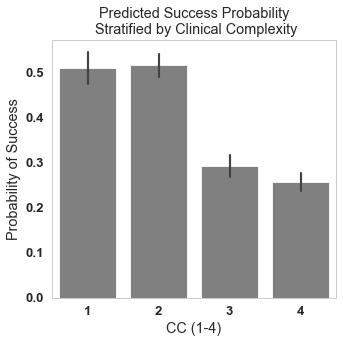

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
sns.barplot(x='CC', y='CS', data=cc_df, ax=ax, color='gray')
ax.set(
    ylabel='Probability of Success',
    xlabel='CC (1-4)',
    title='Predicted Success Probability\n Stratified by Clinical Complexity'
)

#     ax = axs[1]
#     sns.barplot(x='CC', y='CS', data=cc_df[cc_df['ENGEL'] != 1], ax=ax, color='gray')
    
#     ax.set(
#         ylabel=None,
#         xlabel=None,
#         title='Failed Outcomes'
# #         xlabel='Clinical Complexity (1-4)',
#     )
#     fig.text(0.5, -0.04, 'Clinical Complexity (CC = 1-4)', ha='center')
#     ax.set_title(f'{feature_name.capitalize()} CS Over \n Cross-Validation Held-Out Test Sets', weight='bold')
#     ax.set_xticklabels(['I', 'II', 'III', 'IV'])
#     fig.suptitle(f'{feature_name.capitalize()} CS Stratified \n By Surgical Outcome')
fig.tight_layout()
figpath = figdir / 'cc_stratified'
figpath = Path(f'/Users/adam2392/Dropbox/Apps/Overleaf/Models of Intracranial EEG Networks For Epileptogenic Zone Localization/figures/figure5-clinical_covariates/')

figpath.mkdir(exist_ok=True)
fig.savefig(figpath / f'{feature_name}_cc_stratified_barplot.pdf')

In [41]:
# cc_df_melt = pd.melt(cc_df, value_name='Value', var_name='')

In [42]:
display(cc_df.head())

cc_df['ENGEL'] = cc_df['ENGEL'].astype(str)
cc_df['CC'] = cc_df['CC'].astype(str)

,CS,CC,ILAE,ENGEL,cv_index
0,0.122,4,6,4,0
1,0.168,4,6,4,0
2,0.258,4,6,4,0
3,0.174,4,6,4,0
4,0.192,3,6,4,0


In [43]:
cc_dabest = dabest.load(cc_df, 
                        x='CC', y='CS', 
#                         idx=(
#                             ['2', '3'],
#                              ['2', '4'],
#                              ['3', '4'],
#                             ),
                        idx=['1','2','3','4'],
#                         idx=sorted(cc_df['ENGEL'].unique()), 
                        ci=95)
                                
cc_dabest.cohens_d

DABEST v0.3.0
             
Good afternoon!
The current time is Tue Sep  8 17:20:11 2020.

The unpaired Cohen's d between 1 and 2 is 0.02 [95%CI -0.119, 0.157].
The p-value of the two-sided permutation t-test is 0.76. 

The unpaired Cohen's d between 1 and 3 is -0.779 [95%CI -0.941, -0.615].
The p-value of the two-sided permutation t-test is 0.0. 

The unpaired Cohen's d between 1 and 4 is -0.962 [95%CI -1.14, -0.806].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [44]:
display(cc_dabest.cohens_d.lqrtrt)

AttributeError: 'EffectSizeDataFrame' object has no attribute 'lqrtrt'

In [ ]:
display(cc_dabest.cohens_d.results)

# Interpretability

In [ ]:
def _get_subject_scores(scores, subjects):
    sub_scores = dict()
    for idx, (subject, score) in enumerate(zip(subjects, scores)):
        if subject not in sub_scores:
            sub_scores[subject] = np.mean(score)
            
    return sub_scores

In [ ]:
pat_df = read_clinical_excel(excel_fpath, keep_as_df=True)

In [ ]:
interp_fpaths = [f for f in study_path.glob('*') if f.suffix == '.json']

names = []
scores = []
results = []

avg_scores = dict()
fig, ax = plt.subplots()
print(len(interp_fpaths))

for fpath in interp_fpaths:
    feature_name = fpath.name.split('_')[-1].split('.')[0]
    with open(fpath, 'r') as fin:
        interp_scores = json.load(fin)
        
    soz_list = interp_scores['spatial_soz']
    sozc_list = interp_scores['spatial_sozc']
    subject_groups = interp_scores['subjects']

    ratios = []
    outcomes = []
    for soz, sozc, subject in zip(soz_list, sozc_list, subject_groups):
        # use excel file to set various data points
        pat_row = pat_df[pat_df['PATIENT_ID'] == subject.upper()]
        cc = pat_row['CLINICAL_COMPLEXITY'].values[0]
        outcome = pat_row['OUTCOME'].values[0]

        ratios.append(np.nanmean(soz) / (np.nanmean(sozc) + np.nanmean(soz)))
        outcomes.append(outcome)

    df = pd.DataFrame(np.vstack((ratios, outcomes)).T, 
#                       columns=('soz', 'sozc')
                        columns=['score', 'outcome']
                     )
#     df = pd.melt(df, var_name='outcome', value_name='score')
    df[df['score'] == 'nan'] = 0
    df['score'] = pd.to_numeric(df['score'])

    print(feature_name)
    soz_dabest = dabest.load(df, x='outcome', y='score', 
#                         idx=(
#                             ['2', '3'],
#                              ['2', '4'],
#                              ['3', '4'],
#                             ),
                        idx=['S','F'],
#                         idx=sorted(cc_df['ENGEL'].unique()), 
                        ci=95)
    soz_dabest.cohens_d.plot()
    display(soz_dabest.cohens_d.results)
    es = soz_dabest.cohens_d.results['difference'].values
    results.append(soz_dabest.cohens_d.results)
    names.append(feature_name)

In [ ]:
pvals = {}
for name, result in zip(names, results):
    pval = result['pvalue_mann_whitney'].values[0]
    pvals[name] = pval
    
pprint(pvals)

In [ ]:
# map feature names to short-hand
names = [x.replace('coherence', 'coh').
                          replace('degree', 'deg').
                          replace('centrality', 'cent').
                          replace('correlation', 'corr').capitalize() for x in names]


In [ ]:
feat_es = []
y_errs = []
for name, result in zip(names, results):
    es, lb, ub = result['difference'].values[0], result['bca_low'].values[0], result['bca_high'].values[0]
    feat_es.append(np.abs(es))
    y_errs.append(np.abs((ub+lb))/2 - np.abs(es))
    
idx_order = np.argsort(feat_es)
    
colors = ['gray'] * len(idx_order)
colors[-1] = 'red'

sns.set_context('paper', font_scale=1.5)
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x=np.arange(len(names)), color=colors,
       height=np.array(feat_es)[idx_order], 
       yerr=np.array(y_errs)[idx_order], 
       tick_label=np.array(names)[idx_order])
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, 
                   rotation = 45, ha="right")
# statistical annotation
x1, x2 = 19, 20  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = np.max(feat_es) + 0.075, 0.01, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h/2.5, "*", ha='center', va='bottom', color=col)
ylim = ax.get_ylim()
ax.set_ylim([ylim[0], ylim[1]+0.1])

ax.set(
    title=f'Interpretability Ratios of Features \nStratified By Surgical Outcomes',
      ylabel="Absolute Effect Size \n(Cohen's D)",
      xlabel='Feature \n (Ordered by Mean)'
)
# fig.savefig(figdir / 'figure6-interpretability/quantile_ratios_samehyperparameters.pdf', 
#             bbox_inches='tight')

# Visualize Raw EEG Data

In [7]:
import os
import sys
import numpy as np
import collections
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from pprint import pprint
import copy
import mne
from natsort import natsorted

import mne_bids
from mne_bids import BIDSPath

import matplotlib as mp
import matplotlib.pyplot as plt
# matplotlib.use("Agg") # set matplotlib to use the backend that does not require a windowing system
from matplotlib import rc, ticker, cm
from pylab import *
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib

from mne import events_from_annotations

# from eztrack
from eztrack.io import read_raw_eztrack, read_clinical_excel
from eztrack.utils.annotations import (
    _map_events_to_window,
    _find_sz_id,
    _find_clin_onset_id,
)

%matplotlib inline
# Import magic commands for jupyter notebook 
%load_ext autoreload
# %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
bids_root = '/Users/adam2392/Dropbox/epilepsy_bids/'

subject = 'jh103'
session = 'presurgery'
task = 'ictal'
acquisition = 'ecog'
run = '01'
suffix = 'ieeg'

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=suffix, root=bids_root)
print(bids_path)

/Users/adam2392/Dropbox/epilepsy_bids/sub-jh103/ses-presurgery/ieeg/sub-jh103_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.vhdr


In [197]:
# load in the raw data
raw = read_raw_eztrack(bids_path, validate=True, verbose=False)

events, events_id = events_from_annotations(raw)

In [198]:
pat_df = read_clinical_excel(excel_fpath, keep_as_df=True)
display(pat_df.head())


# use excel file to set various data points
pat_row = pat_df[pat_df['PATIENT_ID'] == subject.upper()]
soz_chs = pat_row['SOZ_CONTACTS'].values[0]

print(soz_chs)

,JOURNAL_PATIENTID,PATIENT_ID,NUMBER_DATASETS,CLINICAL_CENTER,MODALITY,SFREQ,PREVIOUS SURGERY?,CLINICAL_COMPLEXITY,ENGEL_SCORE,ILAE_SCORE,...,DATE/YEAR OF SURGERY,DATE_LAST_FOLLOW_UP,YEARS_FOLLOW_UP,NOTES,PREVIOUS - FOLLOWUP,UNNAMED: 39,UNNAMED: 40,UNNAMED: 41,UNNAMED: 42,UNNAMED: 43
0,PATIENT_1,PT1,4.0,NIH,ECOG,1000.0,n/a,1.0,1.0,2.0,...,NAT,2019-05-15,3.0,n/a,2017-04-26,n/a,n/a,n/a,n/a,n/a
1,PATIENT_2,PT2,3.0,NIH,ECOG,1000.0,n/a,1.0,1.0,1.0,...,NAT,2020-01-16,3.0,n/a,2017-03-16,n/a,n/a,n/a,n/a,n/a
2,PATIENT_3,PT3,2.0,NIH,ECOG,1000.0,n/a,3.0,1.0,1.0,...,NAT,2017-03-02,2.0,n/a,2017-03-02,n/a,n/a,n/a,n/a,n/a
3,PATIENT_4,PT6,3.0,NIH,ECOG,1000.0,n/a,4.0,2.0,5.0,...,NAT,2019-01-03,3.0,n/a,2016-12-09,n/a,n/a,n/a,n/a,n/a
4,PATIENT_5,PT7,3.0,NIH,ECOG,1000.0,n/a,3.0,3.0,1.0,...,NAT,2020-02-14,7.0,n/a,2017-04-26,n/a,n/a,n/a,n/a,n/a


['RTG40', 'RTG48', 'RAD1', 'RAD2', 'RAD3', 'RAD4', 'RAD5', 'RAD6', 'RAD7', 'RAD8', 'RHD1', 'RHD2', 'RHD3', 'RHD4', 'RHD5', 'RHD6', 'RHD7', 'RHD8', 'RHD9']


In [199]:
chs_to_plot = soz_chs.copy()
if subject == "pt1":
    chs_to_plot.extend(
        ["ilt1", "ilt2", "ilt3", "ilt4",
#         "mlt1", "mlt2", "mlt3", "mlt4",
#          "slt1", "slt2", "slt3", "slt4",
        ]
    )
elif subject == "jh103":
    chs_to_plot.extend(
        [
            "abt1", "abt2",
#             "pbt1", "ptbt2", "pbt3", "pbt4",
#          "rtg5", "rtg6", "rtg7",  "rtg8",  "rtg9",  "rtg10",
            "rtg29", "rtg30", "rtg31",  "rtg32",  
#             "rtg33",  "rtg34",
#            "rtg39", "rtg35", "rtg36",  "rtg37",  "rtg38",  
        ]
    )
elif subject == "la08":
    chs_to_plot.extend(
        [
           "x'1", "f'2", "n'4", "n'5", "n'6", "m'4", "m'5", "u'1", "u'2", "u'3",
        ]
    )
    
chs_to_plot = [ch.upper() for ch in chs_to_plot]

In [200]:
# find the seizure onset and offset
sz_onset_id, sz_offset_id = _find_sz_id(events_id, verbose=False)

print(sz_onset_id)
# sz_onset_id = 10008
sz_event = events[np.where(events[:, -1] == sz_onset_id)]
sz_onset = sz_event[0][0].squeeze()

print(events_id)
print(sz_event)
print(sz_onset)

10022
{'+0.000000': 10001, '+105.000000': 10002, '+111.000000': 10003, '+118.000000': 10004, '+125.000000': 10005, '+139.000000': 10006, '+160.000000': 10007, '+60.000000': 10008, '+62.000000': 10009, '+65.000000': 10010, '+69.000000': 10011, '+71.000000': 10012, '+80.000000': 10013, '+82.000000': 10014, '+83.000000': 10015, '+84.000000': 10016, '+86.000000': 10017, '+95.000000': 10018, '+96.000000': 10019, '+98.000000': 10020, 'A1+A2 OFF': 10021, 'SZ EVENT # (PB SZ)': 10022, 'Schedule': 10023, 'Segment: REC START REC EEG': 10024, 'Z BLINKING': 10025, 'Z DEVOLUTION': 10026, 'Z DROOLING': 10027, 'Z GENERALIZE': 10028, 'Z ICTAL BUILD': 10029, 'Z OPENS MOUTH, HEAD': 10030, 'Z OXYGEN STARTING': 10031, 'Z POST-ICTAL DEPRESS': 10032, 'Z RHD 39-40, 47-48': 10033, 'Z RHD>RAD': 10034, 'Z RHY ALPHA RHD5': 10035, 'Z SCREAMING': 10036, 'Z SEMIRHY SLOW RHD': 10037, 'Z SLEEPING': 10038, 'Z SPK/SLW RAD, RHD>A': 10039, 'Z SPREAD TO RHD, ABT': 10040, 'Z STIFFENING': 10041, 'Z TURNED ON SIDE': 10042, 'Z

In [201]:
start = sz_onset / raw.info['sfreq'] - 10#.*raw.info['sfreq']

chinds = [i for i, ch in enumerate(raw.ch_names) if ch in chs_to_plot]
raw._first_samp = start

In [202]:

raw.resample(30)
print(raw)
raw.load_data()

<RawBrainVision | sub-jh103_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg, 88 x 6185 (206.1 s), ~4.3 MB, data loaded>


<RawBrainVision | sub-jh103_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg, 88 x 6185 (206.1 s), ~4.3 MB, data loaded>

In [203]:
raw.set_annotations(None)

<RawBrainVision | sub-jh103_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg, 88 x 6185 (206.1 s), ~4.3 MB, data loaded>

In [204]:
print(figdir)
print(start)

/Users/adam2392/Dropbox/Apps/Overleaf/Models of Intracranial EEG Networks For Epileptogenic Zone Localization/figures
49.892


Figure(747x576)


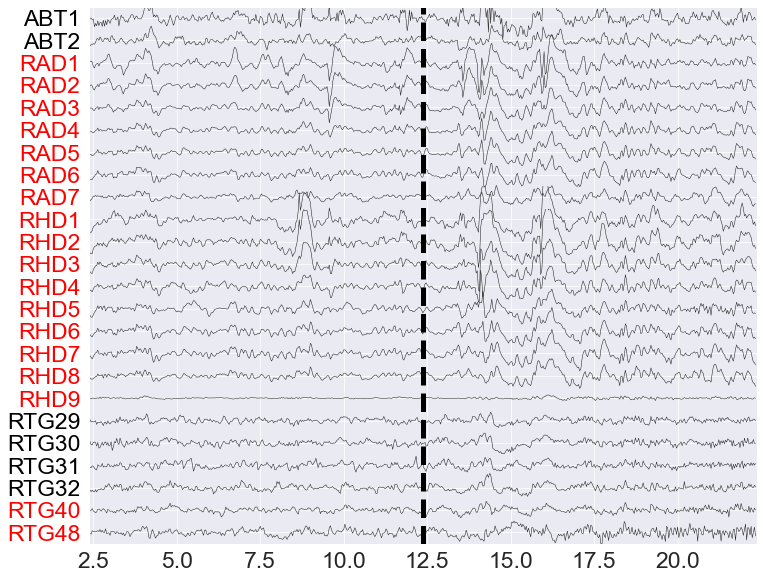

In [206]:

sns.set(context="paper", 
        font_scale=2.6
       )
# matplotlib.rc('figure', figsize=(25, 7))

fig = raw.plot(
            events=None,
            duration=20, 
            n_channels=len(chinds),
            color={"eeg": "black", 
                   "seeg": 'black'},
             order=chinds,
             scalings={
                 'seeg': 5e-4,
                 'ecog': 2e-4, 
#                        'eog': 5e-4
                      },
#             decim=2,
#         show_first_samp=True, 
        show=False,
#          clipping='clamp',
         start=start, 
        show_scrollbars=False,
        show_scalebars=False,
              )

ax = fig.axes[0]
# ax.set_xticks(np.linspace(0, 20, 9))
ax.set_xticklabels(np.linspace(0, 20, 9))

xlim = ax.get_xlim()
ax.axvline(np.mean(xlim), lw=5, color='black', ls='--')

yticklabels = ax.get_yticklabels()
# set colors based on lists passed in
for idx, y_label in enumerate(yticklabels):
    y_ch = y_label.get_text()
    
    if y_ch in soz_chs:
        color = 'red'
    else:
        color = 'black'


    # set the color for each of these ylabels
    yticklabels[idx].set_color(color)

# fig.set_figwidth(12)
fig.set_figheight(8)
fig.savefig(figdir / 'figure3-exampleheatmaps' / 'raweeg' / f"raw_{subject}_eeg_{reference}.pdf", 
            dpi=1000,
            bbox_inches="tight")
print(fig)